# Trader Performance vs Market Sentiment Analysis

Primetrade.ai – Data Science Assignment


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

In [12]:
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

print("Trades columns:")
print(trades.columns.tolist())

print("\nSentiment columns:")
print(sentiment.columns.tolist())

Trades columns:
['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Sentiment columns:
['timestamp', 'value', 'classification', 'date']


In [13]:
# Detect timestamp column
time_col = None
for col in trades.columns:
    if any(k in col.lower() for k in ['time', 'date', 'created', 'executed']):
        time_col = col
        break

if time_col is None:
    raise Exception("Timestamp column not found")

print(f"Using timestamp column: {time_col}")

# Parse datetime safely (DD-MM-YYYY)
trades['time'] = pd.to_datetime(
    trades[time_col],
    dayfirst=True,
    format='mixed',
    errors='coerce'
)

trades = trades.dropna(subset=['time'])
trades['date'] = trades['time'].dt.date

trades.head()

Using timestamp column: Timestamp IST


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,time,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02


In [14]:
account_col = None
for col in trades.columns:
    if any(k in col.lower() for k in ['account', 'user', 'wallet', 'address', 'trader']):
        account_col = col
        break

if account_col is None:
    raise Exception("Account column not found")

print(f"Using account column: {account_col}")

Using account column: Account


In [15]:
pnl_col = None
for col in trades.columns:
    if any(k in col.lower() for k in ['pnl', 'profit', 'gain', 'loss']):
        pnl_col = col
        break

if pnl_col is None:
    raise Exception("PnL column not found")

print(f"Using PnL column: {pnl_col}")

Using PnL column: Closed PnL


In [18]:
# --- FIX sentiment timestamp (UNIX seconds) ---

print("Sentiment columns:", sentiment.columns.tolist())

# Convert UNIX timestamp (seconds) to proper date
sentiment['date'] = pd.to_datetime(
    sentiment['timestamp'],
    unit='s',
    utc=True
).dt.date

sentiment.head()

Sentiment columns: ['timestamp', 'value', 'classification', 'date']


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [20]:
daily_perf = trades.groupby([account_col, 'date']).agg(
    daily_pnl=(pnl_col, 'sum'),
    trades_count=(pnl_col, 'count'),
    wins=(pnl_col, lambda x: (x > 0).sum())
).reset_index()

daily_perf['win_rate'] = daily_perf['wins'] / daily_perf['trades_count']
daily_perf.head()

,Account,date,daily_pnl,trades_count,wins,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,0,0.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,0,0.000000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,0,0.000000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,0,0.000000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,27,12,0.444444


In [21]:
data = daily_perf.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

data.head()

,Account,date,daily_pnl,trades_count,wins,win_rate,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,0,0.000000,Extreme Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,0,0.000000,Extreme Greed
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,0,0.000000,Extreme Greed
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,0,0.000000,Extreme Greed
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,27,12,0.444444,Extreme Greed


In [22]:
def sentiment_bucket(x):
    if x in ['Extreme Fear', 'Fear']:
        return 'Fear'
    elif x in ['Extreme Greed', 'Greed']:
        return 'Greed'
    else:
        return 'Neutral'

data['sentiment_regime'] = data['classification'].apply(sentiment_bucket)
data['sentiment_regime'].value_counts()

sentiment_regime
Greed      1174
Fear        790
Neutral     377
Name: count, dtype: int64

In [23]:
def sharpe_ratio(pnl):
    return pnl.mean() / pnl.std() if pnl.std() != 0 else 0

def max_drawdown(pnl):
    cumulative = pnl.cumsum()
    peak = cumulative.cummax()
    return (cumulative - peak).min()

In [24]:
summary = data.groupby([account_col, 'sentiment_regime']).agg(
    total_pnl=('daily_pnl', 'sum'),
    avg_pnl=('daily_pnl', 'mean'),
    win_rate=('win_rate', 'mean'),
    sharpe=('daily_pnl', sharpe_ratio),
    max_drawdown=('daily_pnl', max_drawdown)
).reset_index()

summary.head()

,Account,sentiment_regime,total_pnl,avg_pnl,win_rate,sharpe,max_drawdown
0,0x083384f897ee0f19899168e3b1bec365f52a9012,Fear,1.238143e+06,176877.538422,0.531962,0.966744,0.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,Greed,2.364369e+05,19703.077857,0.174936,0.146925,-327505.900056
2,0x083384f897ee0f19899168e3b1bec365f52a9012,Neutral,1.256501e+05,25130.023348,0.526605,1.303112,0.000000
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Fear,-5.893890e+03,-294.694493,0.377707,-0.121573,-5100.872639
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Greed,6.571229e+04,2433.788537,0.431447,0.752314,-4648.871055


In [25]:
top_fear = summary[summary['sentiment_regime'] == 'Fear'] \
    .sort_values('total_pnl', ascending=False).head(10)

top_greed = summary[summary['sentiment_regime'] == 'Greed'] \
    .sort_values('total_pnl', ascending=False).head(10)

top_fear, top_greed

(                                       Account sentiment_regime     total_pnl  \
 0   0x083384f897ee0f19899168e3b1bec365f52a9012             Fear  1.238143e+06   
 85  0xbaaaf6571ab7d571043ff1e313a9609a10637864             Fear  8.827904e+05   
 33  0x4acb90e786d897ecffb614dc822eb231b4ffb9f4             Fear  4.634781e+05   
 48  0x72c6a4624e1dffa724e6d00d64ceae698af892a0             Fear  3.434149e+05   
 39  0x513b8629fe877bb581bf244e326a047b249c4ff1             Fear  2.960444e+05   
 88  0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3             Fear  2.745103e+05   
 57  0x8170715b3b381dffb7062c0298972d4727a0a63b             Fear  1.640062e+05   
 24  0x420ab45e0bd8863569a5efbb9c05d91f40624641             Fear  1.091094e+05   
 80  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23             Fear  1.027101e+05   
 91  0xbee1707d6b44d4d52bfe19e41f8a828645437aab             Fear  8.675289e+04   
 
           avg_pnl  win_rate    sharpe  max_drawdown  
 0   176877.538422  0.531962  0.966744   

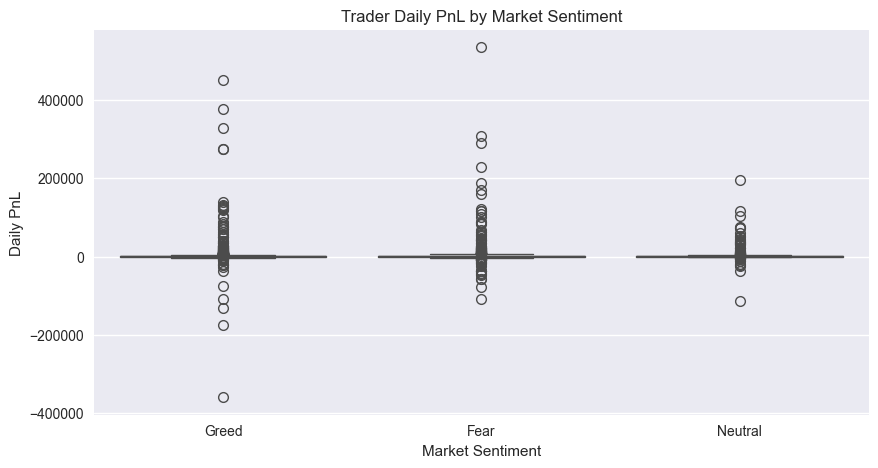

In [26]:
plt.figure(figsize=(10,5))
sns.boxplot(data=data, x='sentiment_regime', y='daily_pnl')
plt.title("Trader Daily PnL by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL")
plt.show()

In [27]:
# --- Contrarian Score: performance during Fear vs Greed ---

pivot = summary.pivot(
    index=account_col,
    columns='sentiment_regime',
    values='total_pnl'
).fillna(0)

pivot['contrarian_score'] = pivot.get('Fear', 0) - pivot.get('Greed', 0)

pivot.sort_values('contrarian_score', ascending=False).head(10)

sentiment_regime,Fear,Greed,Neutral,contrarian_score
Account,,,,
0x083384f897ee0f19899168e3b1bec365f52a9012,1.238143e+06,236436.934283,125650.116740,1.001706e+06
0xbaaaf6571ab7d571043ff1e313a9609a10637864,8.827904e+05,4.672458,57368.780126,8.827857e+05
0x8170715b3b381dffb7062c0298972d4727a0a63b,1.640062e+05,-379237.811515,47610.460744,5.432440e+05
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,4.634781e+05,116888.837368,97380.090931,3.465893e+05
0x72c6a4624e1dffa724e6d00d64ceae698af892a0,3.434149e+05,21651.302288,37945.295661,3.217636e+05
0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,2.745103e+05,36311.364425,-90302.553718,2.381989e+05
0x271b280974205ca63b716753467d5a371de622ab,4.682880e+04,-98226.646159,-19038.340561,1.450554e+05
0x513b8629fe877bb581bf244e326a047b249c4ff1,2.960444e+05,163047.664946,381330.494050,1.329967e+05
0x420ab45e0bd8863569a5efbb9c05d91f40624641,1.091094e+05,16102.568590,74293.663505,9.300679e+04


In [28]:
# --- Consistent traders across regimes ---

consistent = summary.groupby(account_col).agg(
    avg_total_pnl=('total_pnl', 'mean'),
    avg_sharpe=('sharpe', 'mean')
).reset_index()

consistent.sort_values(
    ['avg_total_pnl', 'avg_sharpe'],
    ascending=False
).head(10)

,Account,avg_total_pnl,avg_sharpe
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,714460.865896,0.273521
0,0x083384f897ee0f19899168e3b1bec365f52a9012,533409.939993,0.805594
29,0xbaaaf6571ab7d571043ff1e313a9609a10637864,313387.935407,0.665573
13,0x513b8629fe877bb581bf244e326a047b249c4ff1,280140.851739,0.565984
31,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,278693.517692,0.324168
11,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,225915.683548,0.516714
15,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,143118.521972,0.198421
9,0x430f09841d65beb3f27765503d0f850b8bce7713,138847.290780,0.557291
16,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,134337.168053,0.320256
17,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,126365.135570,0.403878


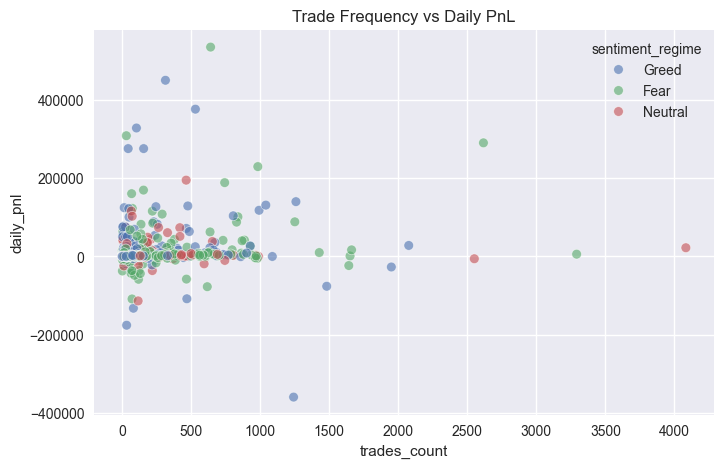

In [29]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=data,
    x='trades_count',
    y='daily_pnl',
    hue='sentiment_regime',
    alpha=0.6
)
plt.title("Trade Frequency vs Daily PnL")
plt.show()